<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Thank you for taking the time to improve the project! It is accepted now. Good luck on the next sprint!

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are a couple of problems that need to be fixed before the project is accepted. Let me know if you have any questions!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Initialization

In [1]:
# Load up all necesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
# Create data frame
df = pd.read_csv('/datasets/taxi.csv', parse_dates= [0], index_col=[0])

In [3]:
# Visualize data frame
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data and appropriate libraries have been loaded up and are ready for preprocessing

### Preprocessing

In [5]:
# Check if data is in chronological order
df.index.is_monotonic

True

The data is already arranged in chronological order

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good idea to check this!

</div>

In [6]:
# Resample data
df = df.resample('1H').sum()

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was resampled correctly

</div>

With this we have ordered the data hourly. Lets see what our data looks like on a graph

<AxesSubplot:xlabel='datetime'>

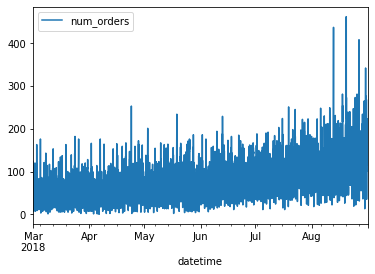

In [7]:
df.plot()

The plot reveals the whole data. We can see that this data is non stationary which could be a problem when training time series models.

In [8]:
# Get timeseries difference
data = df-df.shift()

data['num_orders'] = data['num_orders'].fillna(0)

In [9]:
# Create rolling mean column
data['rolling_mean'] = data['num_orders'].rolling(10).mean()

# Create rolling standard deviation column
data['rolling_std'] = data['num_orders'].rolling(10).std()

<AxesSubplot:xlabel='datetime'>

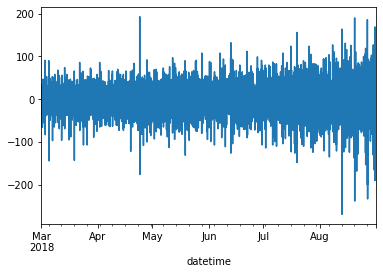

In [10]:
data['num_orders'].plot()

<AxesSubplot:xlabel='datetime'>

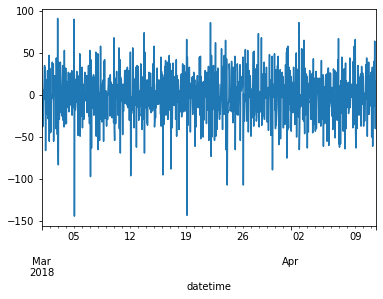

In [11]:
data['num_orders'].head(1000).plot()

In [12]:
data

,num_orders,rolling_mean,rolling_std
datetime,,,
2018-03-01 00:00:00,0.0,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,-71.0,-6.7,41.649463
2018-08-31 20:00:00,18.0,-3.7,42.300644
2018-08-31 21:00:00,5.0,-0.8,41.744727


Now we have a more stationary dataset. We could as well try one more method

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright!

</div>

In [13]:
# Log transorm dataset
df_log = np.log(df+1)

In [14]:
# Visualize transformed dataset
df_log

,num_orders
datetime,
2018-03-01 00:00:00,4.828314
2018-03-01 01:00:00,4.454347
2018-03-01 02:00:00,4.276666
2018-03-01 03:00:00,4.204693
2018-03-01 04:00:00,3.784190
...,...
2018-08-31 19:00:00,4.919981
2018-08-31 20:00:00,5.043425
2018-08-31 21:00:00,5.075174


<AxesSubplot:xlabel='datetime'>

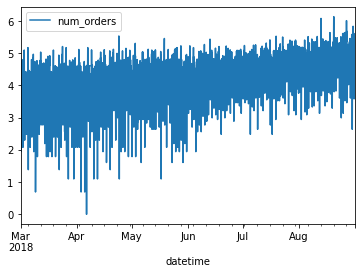

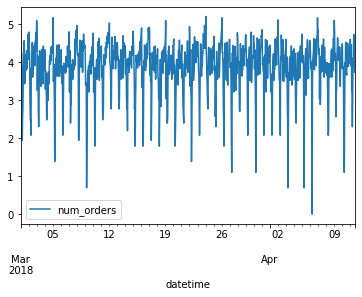

In [15]:
# Plot transformed df
df_log.plot()

df_log.head(1000).plot()

Log transforms are popular with time series data as they are effective at removing exponential variance.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

If you use log transformed data you need to apply the inverse transformation when making predictions, because these transformations affect the value of RMSE.

</div>

## Analysis

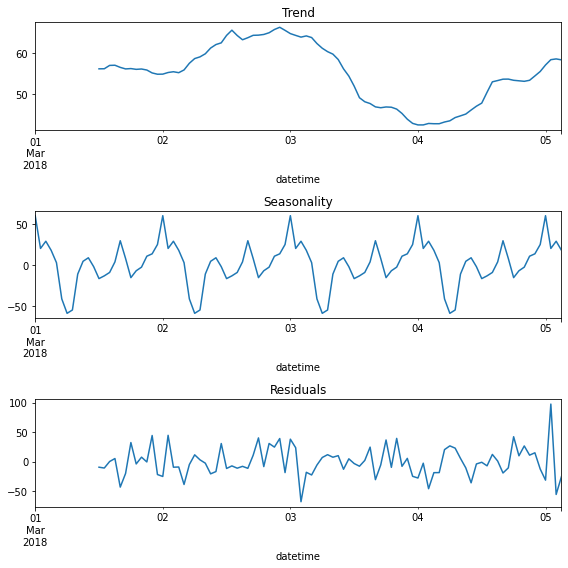

In [16]:
# Get seasonality and trend
decomposed = seasonal_decompose(df['num_orders'])

# Create plots
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.head(100).plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.head(100).plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.head(100).plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout() 

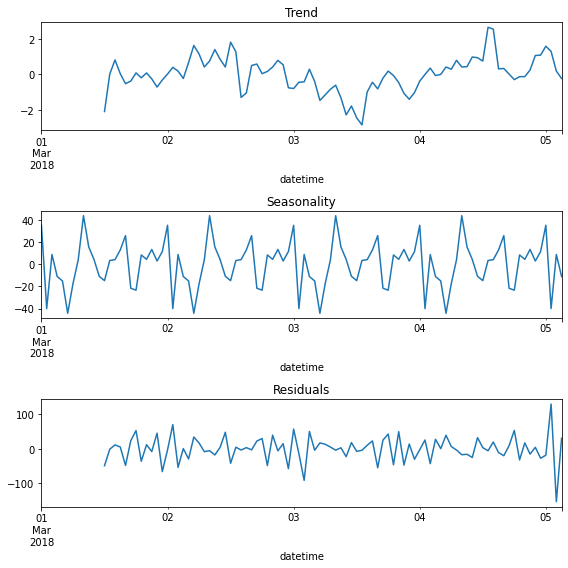

In [17]:
# Get seasonality and trend
decomposed = seasonal_decompose(data['num_orders'])

# Create plots
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.head(100).plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.head(100).plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.head(100).plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout() 

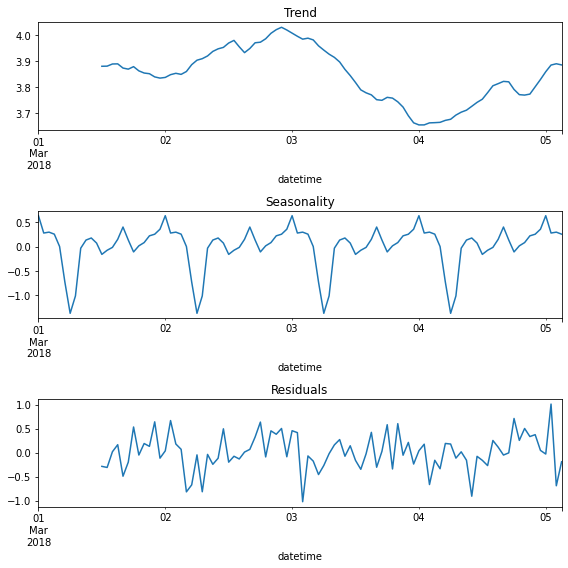

In [18]:
# Get seasonality and trend
decomposed = seasonal_decompose(df_log['num_orders'])

# Create plots
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.head(100).plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.head(100).plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.head(100).plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout() 

From the above plots, We can see how each method affects the plots and outlook of the data. For this exercise though, we'll be using the original dataset.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Instead of doing a decomposition of a small slice of data, I would suggest using the full dataset for decomposition, and then taking a look at a smaller slice of `decomposed.seasonal` instead :)

</div>

In [19]:
# Split data into training and test datasets
train, test = train_test_split(df, test_size = 0.1, shuffle=False)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test without shuffling

</div>

In [20]:
# Forcast without training 
print('Median daily taxi orders:', test['num_orders'].median())

pred_previous = test.shift()
pred_previous.fillna(train.iloc[train.size-1], inplace=True)
result =  mean_squared_error(test, pred_previous) 
print('RMSE:', result**0.5)

Median daily taxi orders: 135.0
RMSE: 58.856486242815066


We can use this as a sanity check for our models

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Great, there's a baseline! Another simple baseline that often produces better results than a constant is using previous value as prediction

</div>

## Training

In [21]:
# Create features for training
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 10, 5)
print(df.head())

                     num_orders  year  month  day  dayofweek  hour  lag_1  \
datetime                                                                    
2018-03-01 00:00:00         124  2018      3    1          3     0    NaN   
2018-03-01 01:00:00          85  2018      3    1          3     1  124.0   
2018-03-01 02:00:00          71  2018      3    1          3     2   85.0   
2018-03-01 03:00:00          66  2018      3    1          3     3   71.0   
2018-03-01 04:00:00          43  2018      3    1          3     4   66.0   

                     lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
datetime                                                                      
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 02:00:00  124.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 03:00:00   85.0  124.0    NaN    NaN    NaN    NaN    

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Feature engineering looks good: there are calendar features, lag features and a shifted rolling mean. I would suggest adding an hour feature as we're doing hourly predictions to capture intra-day seasonality

</div>

In [22]:
# Create RMSE function
def rmse(target, pred, **kwargs):
    mse = mean_squared_error(target, pred)
    result = mse**0.5
    return result
    
# Create scorer
scorer = make_scorer(rmse, greater_is_better=False)


<div class="alert alert-warning">
<b>Reviewer's comment</b>

In scikit-learn RMSE one of the [default metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) and can be used with `scoring='neg_root_mean_squared_error'`

</div>

In [23]:
# Split df into features and targets for training and test datasets 
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok!

</div>

All relevant functions have been defined. Now to create the models

### Linear Regression Model

In [26]:
# Create and train model
lr_model = LinearRegression()
lr_result = cross_val_score(lr_model, features_train, target_train, cv=TimeSeriesSplit(), scoring=scorer).mean() *-1
print('RMSE=', lr_result)

RMSE= 31.50113295387454


### Decision tree model

In [25]:
# Create and train model
dt_model = None
max_depth = 0
dt_rmse = float('-inf')
for depth in range(1, 50, 10):
    model = DecisionTreeRegressor(max_depth = depth, random_state=12345)
    result = cross_val_score(model, features_train, target_train, cv=TimeSeriesSplit(), scoring=scorer).mean()
    if result > dt_rmse:
        dt_model = model
        max_depth= depth
        dt_rmse = result * -1
print('max_depth =', max_depth)
print('RMSE =', dt_rmse)

max_depth = 1
RMSE = 36.34936403871058


### Random Forest Model

In [30]:
rf_model = None
rf_max_depth = 0
rf_rmse = float('-inf')
n_est = 0
for depth in range(1, 50, 10):
    for est in range(1, 50, 10):
        model = RandomForestRegressor(n_estimators= est, max_depth = depth, random_state=12345)
        result = cross_val_score(model, features_train, target_train, cv=TimeSeriesSplit(), scoring=scorer).mean()
        if result > rf_rmse:
            rf_model = model
            rf_max_depth= depth
            n_est = est
            rf_rmse = result * -1
print('max_depth =', rf_max_depth)
print('number of estimators =', n_est)
print('RMSE =', rf_rmse)

max_depth = 1
number of estimators = 1
RMSE = 36.087186246752694


### Catboost Model

In [27]:
cb_model = None
iterations = 0
RMSE_2 = float('-inf')
for l in range(100, 200, 50):
    model_2 = CatBoostRegressor(random_seed=12345, iterations=l, verbose=0)
    result_2 = cross_val_score(model_2, features_train, target_train, cv=TimeSeriesSplit(), scoring=scorer).mean()
    if result_2 > RMSE_2:
        cb_model = model_2
        RMSE_2 = result_2 * -1
        iterations = l

In [28]:
RMSE_2

25.79847402278775

### ARIMA model

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


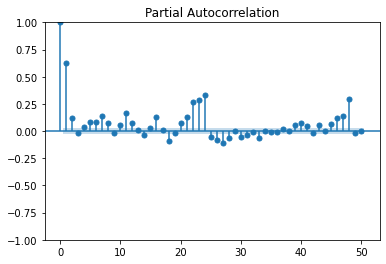

In [29]:
plot_pacf(df['num_orders'], lags=50);

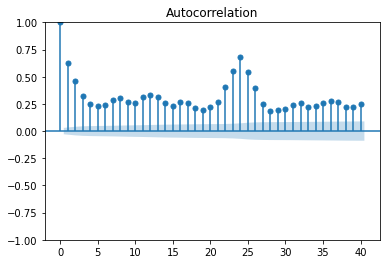

In [30]:
plot_acf(df['num_orders'], lags=40);

In [31]:
arima = ARIMA(df['num_orders'], order=(2,1,2))

result = arima.fit()

print(result.predict(1,264))

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


datetime
2018-03-01 01:00:00    123.947118
2018-03-01 02:00:00     95.923957
2018-03-01 03:00:00     83.522415
2018-03-01 04:00:00     78.818041
2018-03-01 05:00:00     62.386884
                          ...    
2018-03-11 20:00:00     77.123180
2018-03-11 21:00:00     74.558493
2018-03-11 22:00:00     86.866530
2018-03-11 23:00:00     70.475378
2018-03-12 00:00:00     86.695712
Freq: H, Name: predicted_mean, Length: 264, dtype: float64


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Great, your tried a couple of different models and did some hyperparameter tuning using cross-validation. One problem: using regular k-fold validation is not appropriate for time series models due to data leakage (in all folds but one train and validation data are in mixed order). To fix this we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) (just pass an object of this class as the `cv` parameter to `cross_val_score`, `GridSearchCV`, etc.)

</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

Very good! One small problem: setting the parameter `test_size` of `TimeSeriesSplit` to 2 limits the size of validation subsets to just 2 examples, which makes our validation subsets not representative. I suggest using the default value instead. Compare how the data is split using these two options below

</div>

In [52]:
tscv = TimeSeriesSplit(test_size=2)
for train_index, test_index in tscv.split(features_train):
    print(f"TRAIN: [{train_index[0]} ... {train_index[-1]}], TEST: {test_index}")

TRAIN: [0 ... 3953], TEST: [3954 3955]
TRAIN: [0 ... 3955], TEST: [3956 3957]
TRAIN: [0 ... 3957], TEST: [3958 3959]
TRAIN: [0 ... 3959], TEST: [3960 3961]
TRAIN: [0 ... 3961], TEST: [3962 3963]


In [53]:
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(features_train):
    print(f"TRAIN: [{train_index[0]} ... {train_index[-1]}], TEST: [{test_index[0]} ... {test_index[-1]}]")

TRAIN: [0 ... 663], TEST: [664 ... 1323]
TRAIN: [0 ... 1323], TEST: [1324 ... 1983]
TRAIN: [0 ... 1983], TEST: [1984 ... 2643]
TRAIN: [0 ... 2643], TEST: [2644 ... 3303]
TRAIN: [0 ... 3303], TEST: [3304 ... 3963]


<div class="alert alert-info">
  Thanks a lot for this example. It really clears things up as to what actually happens when the test_size is set at a certain number.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Glad it helped you :)

</div>

## Testing

### Catboost model

In [31]:
# Test model and evaluate accuracy
cb_model.fit(features_train, target_train)
cb_pred = cb_model.predict(features_test)
print('RMSE=', rmse(target_test, cb_pred))

RMSE= 47.597488999312404


From our testing and model training, we can see that the catboost model is more accurate in predicting time series than the other models.

<div class="alert alert-danger">
<s>
    <b>Reviewer's comment</b>

1. The test set should only be used to evaluate your single final model. To compare different models please use cross-validation. The reason is that the test set is used to get an unbiased estimate of the final model's generalization performance. If we use it to tune hyperparameters, for model selection or to make any decisions about the model in general, it makes the results inherently biased.
    
2. Another point is that because you applied differencing and log transformation to the data, it's not possible to compare the RMSE of your models to the project threshold which assumes you're working with the original data. So please apply the inverse transformation after making the predictions and use that to calculate RMSE with original targets.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Ok, great!

</div>

I also came accross ARIMA, AR and MA models during my research. But these models were not covered in the course material. If you could share some useful resources where I could read and practice how to use them, that'd be very helpful. Thanks.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Check out [this blog](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/), it has a lot of useful posts on other machine learning topics as well

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48